In [ ]:
# Change the current working directory to the repo root.
# It makes the relative imports easier
import os
from pathlib import Path
from git import Repo
repo = Repo(Path().resolve(), search_parent_directories=True)
project_root = Path(repo.git.rev_parse("--show-toplevel"))
os.chdir(project_root)

# Gomoku Data Generation

In [2]:
import subprocess
import collections
import pandas as pd
from tqdm import tqdm
import shutil

from simulations.gomoku import GameEvent

In [3]:
game_dir = "data/gomoku/"
os.makedirs(game_dir, exist_ok=True) 

In [ ]:
params = {'W': 7, 'n': 4, 'time_limit': 0.1, 'init_blocks': 4, 'add_blocks': 2, 'b': 10}

args = ['python', 'simulations/gomoku.py']
for k, v in params.items():
    flag = f"-{k}" if len(k) == 1 else f"--{k}"
    if isinstance(v, bool):
        if v:
            args.append(flag)
    else:
        args += [flag, str(v)]

print(args)

['python', 'simulations/gomoku.py', '-W', '7', '-n', '4', '--time_limit', '0.1', '--init_blocks', '4', '--add_blocks', '2', '-b', '10']


In [ ]:
# Training set generation
train = []
for i in tqdm(range(100)):
    out_file = os.path.join(game_dir, f"train_{i}.txt")
    cmd = args + ['--output', out_file]
    subprocess.run(cmd, check=True)
    
    # read & parse
    with open(out_file, 'r') as f:
        text = f.read()
    data = eval(text)
    train.append(data[0])

In [9]:
import pickle
with open(os.path.join(game_dir, "_train.pkl"), 'wb') as f:
    pickle.dump(train, f)

In [13]:
# Test set generation
args.append('--generate_cf')

test = []
for i in tqdm(range(100)):
    out_file = os.path.join(game_dir, f"test_{i}.txt")
    cmd = args + ['--output', out_file]
    subprocess.run(cmd, check=True)
    
    # read & parse
    with open(out_file, 'r') as f:
        text = f.read()
    data = eval(text)
    if len(data) == 2:
        test.append(data)

100%|██████████| 100/100 [17:26<00:00, 10.47s/it]


In [16]:
with open(os.path.join(game_dir, "_test.pkl"), 'wb') as f:
    pickle.dump(test, f)

## EDA

In [17]:
def history_to_outcomes(run):
    return len(run), run[-1]

train_outcomes = [history_to_outcomes(run) for run in train]
test_outcomes = []
for run in test:
    observable = history_to_outcomes(run[0])
    alternative = history_to_outcomes(run[1])
    test_outcomes.append((observable, alternative))

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0.5, 1.0, 'Train lengths')

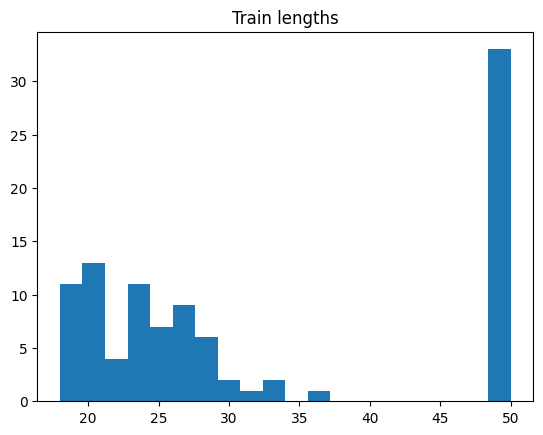

In [19]:
plt.hist([run[0] for run in train_outcomes], bins=20)
plt.title('Train lengths')

Text(0.5, 1.0, 'Test lengths')

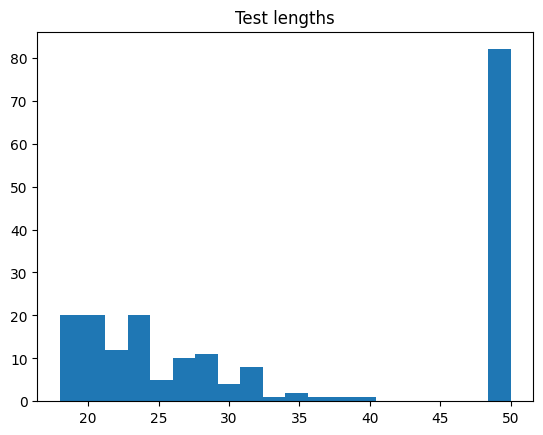

In [23]:
test_flatten = []
for run in test_outcomes:
    test_flatten.extend(run)
plt.hist([run[0] for run in test_flatten], bins=20)
plt.title('Test lengths')

In [21]:
from collections import Counter
Counter([run[1] for run in train_outcomes])

Counter({'1': 41, 'draw': 33, '2': 26})

In [24]:
from collections import Counter
Counter([run[1] for run in test_flatten])

Counter({'draw': 82, '1': 73, '2': 43})

In [50]:
result_to_color = {
    '1': 'blue',
    '2': 'red',
    'draw': 'green'
}

obs_len = []
alter_len = []
obs_result = []
alter_result = []
is_the_result_same = []

for observ, alter in test_outcomes:
    obs_len.append(observ[0])
    alter_len.append(alter[0])
    obs_result.append(observ[1])
    alter_result.append(alter[1])
    if observ[1] == alter[1]:
        is_the_result_same.append(True)
    else:
        is_the_result_same.append(False)

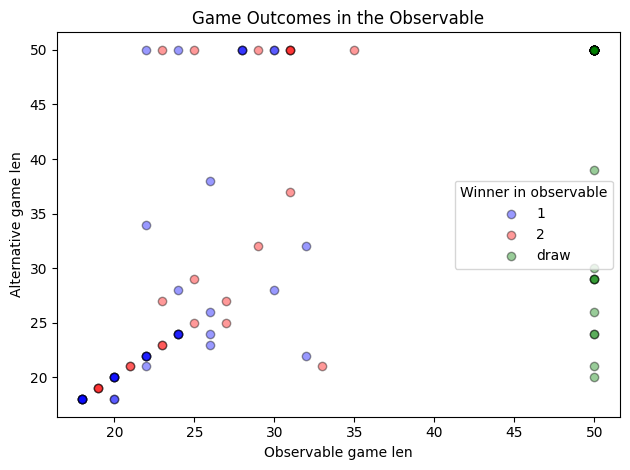

In [ ]:
fig, ax = plt.subplots()

for outcome in result_to_color:
    xs = []
    ys = []

    for i in range(len(obs_len)):
        if obs_result[i] == outcome:
            xs.append(obs_len[i])
            ys.append(alter_len[i])
    ax.scatter(xs, ys,
               c=result_to_color[outcome],
               label=outcome,
               edgecolors='k',       # optional: black edge for clarity
               alpha=0.4)            # optional: slight transparency

plt.xlabel('Observable game len')
plt.ylabel('Alternative game len')
ax.set_title('Game Outcomes in the Observable')
ax.legend(title='Winner in observable')
plt.tight_layout()
plt.show()

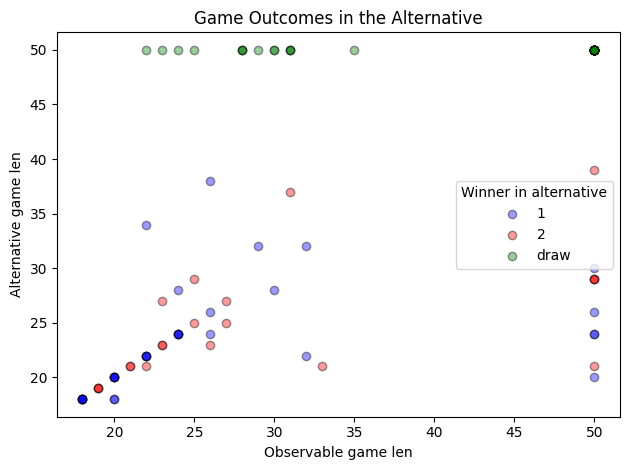

In [49]:
fig, ax = plt.subplots()

for outcome in result_to_color:
    xs = []
    ys = []

    for i in range(len(obs_len)):
        if alter_result[i] == outcome:
            xs.append(obs_len[i])
            ys.append(alter_len[i])
    ax.scatter(xs, ys,
               c=result_to_color[outcome],
               label=outcome,
               edgecolors='k',       # optional: black edge for clarity
               alpha=0.4)            # optional: slight transparency

plt.xlabel('Observable game len')
plt.ylabel('Alternative game len')
ax.set_title('Game Outcomes in the Alternative')
ax.legend(title='Winner in alternative')
plt.tight_layout()
plt.show()

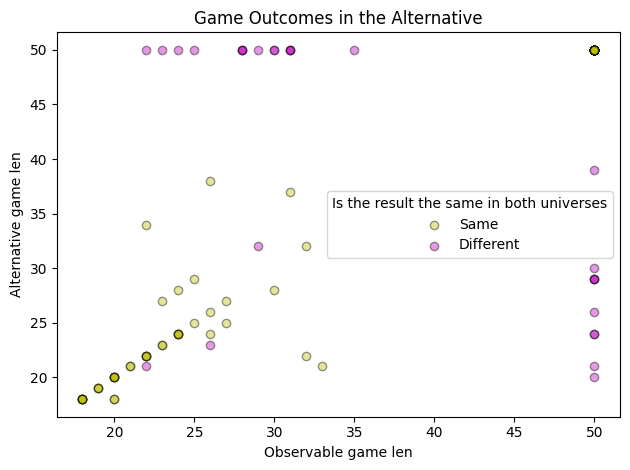

In [51]:
fig, ax = plt.subplots()

for outcome in [True, False]:
    xs = []
    ys = []
    for i in range(len(obs_len)):
        if is_the_result_same[i] == outcome:
            xs.append(obs_len[i])
            ys.append(alter_len[i])
    color = 'y' if outcome else 'm'
    outcome_string = 'Same' if outcome else "Different"
    ax.scatter(xs, ys,
               c=color,
               label=outcome_string,
               edgecolors='k',       # optional: black edge for clarity
               alpha=0.4)            # optional: slight transparency

plt.xlabel('Observable game len')
plt.ylabel('Alternative game len')
ax.set_title('Game Outcomes in the Alternative')
ax.legend(title='Is the result the same in both universes')
plt.tight_layout()
plt.show()